In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
# load data
descriptions = pd.read_excel('DatiProject.xlsx', sheet_name=3)
raw_standard_vars = pd.read_excel('DatiProject.xlsx', sheet_name=0)

In [3]:
# create new columns for needed transformed variables
raw_standard_vars['log_gdp'] = np.log(raw_standard_vars['GDPC1'])
raw_standard_vars['log_cpi'] = np.log(raw_standard_vars['PCECTPI'])
raw_standard_vars['inflation'] = raw_standard_vars['log_cpi'].diff().fillna(0)
raw_standard_vars['tspread'] = raw_standard_vars['GS10'] - raw_standard_vars['TB3MS']
raw_standard_vars['diff_log_gdp'] = raw_standard_vars['log_gdp'].diff().fillna(0)

## Section 1

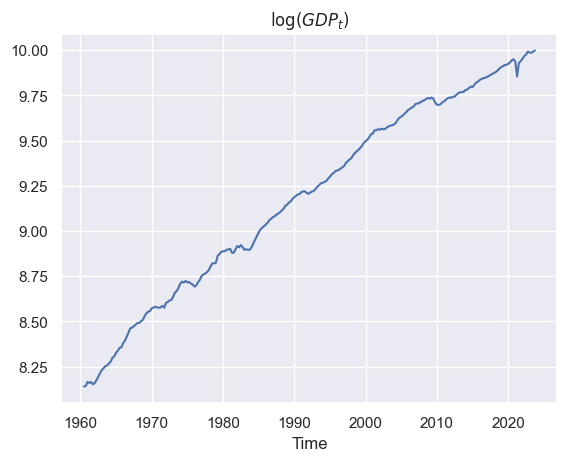

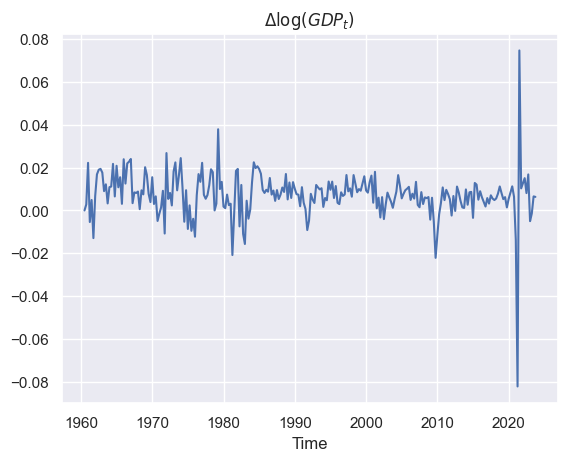

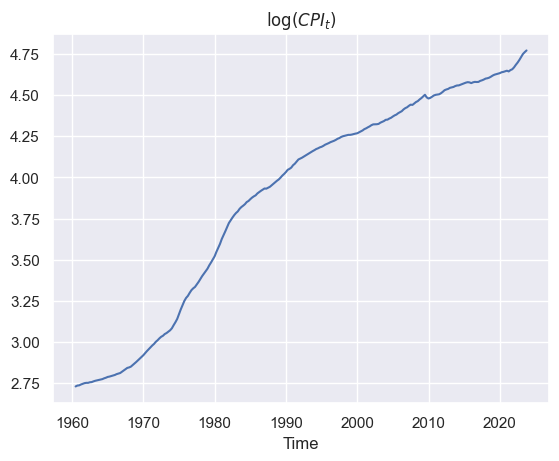

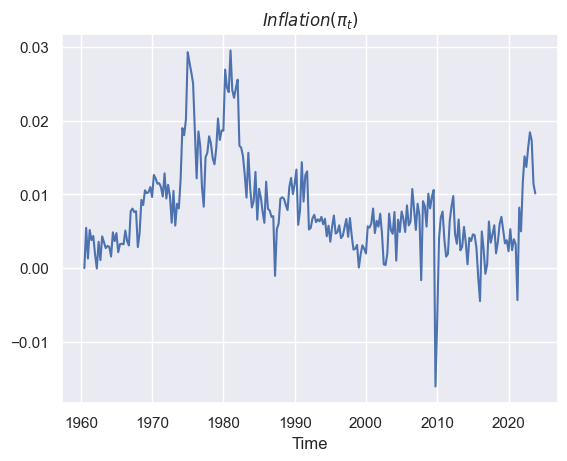

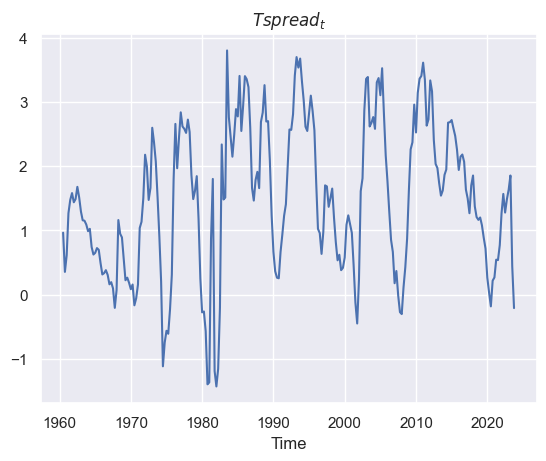

In [4]:
vars_1 = ['log_gdp', 'diff_log_gdp', 'log_cpi', 'inflation', 'tspread']
titles_vars_1 = [r'$\log(GDP_t)$', r'$\Delta \log(GDP_t)$', r'$\log(CPI_t)$', r'$Inflation(\pi_t)$', r'$T spread_t$']

def plot_series(data, vars, titles):
    for v, title in zip(vars, titles):
        sns.set_theme()
        sns.lineplot(data=data, y=v, x='Time')
        plt.title(title)
        plt.ylabel('')
        plt.show()

plot_series(raw_standard_vars, vars_1, titles_vars_1)

## Section 2

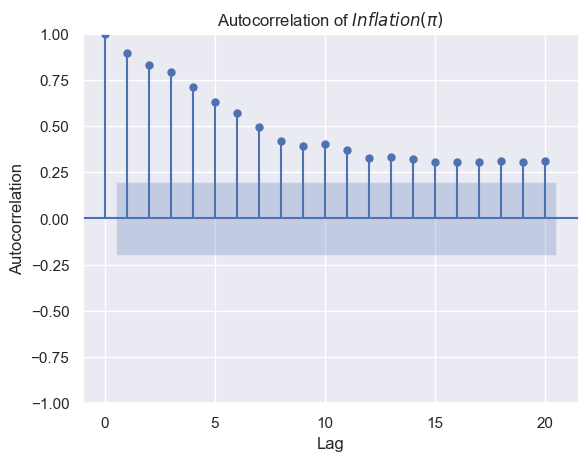

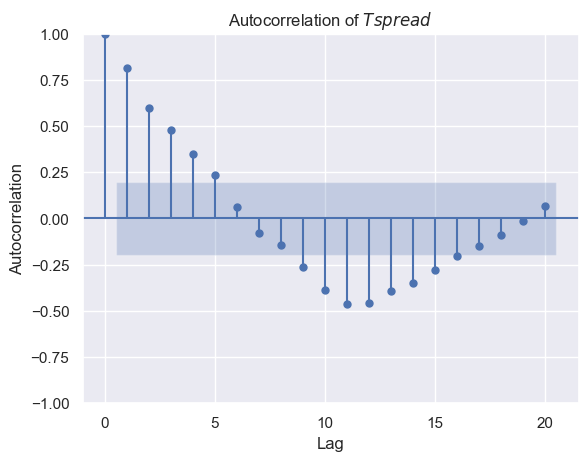

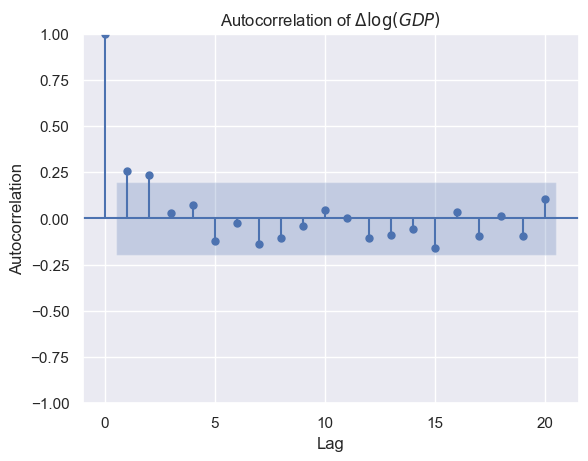

In [5]:
sample_1 = raw_standard_vars[(raw_standard_vars['Time'] < '1985-07-01') & (raw_standard_vars['Time'] > '1960-07-10')].reset_index(drop=True)

columns_autocorr = ['inflation', 'tspread', 'diff_log_gdp']
titles_autocorr = [ r'$Inflation(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(columns_autocorr, titles_autocorr):
    ts = sample_1[column]
    plot_acf(ts, bartlett_confint=False)
    plt.title(f'Autocorrelation of {title}')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

C:\Users\Davide\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


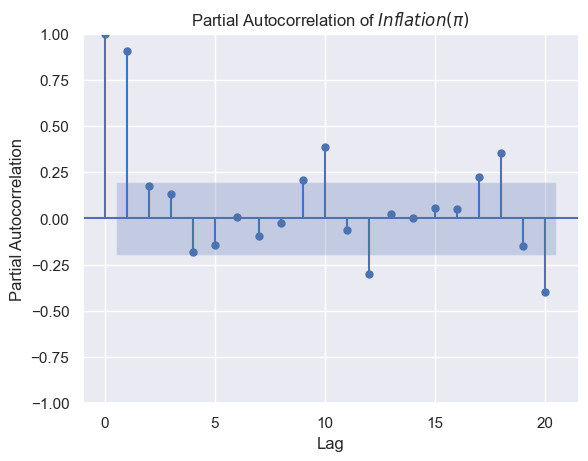

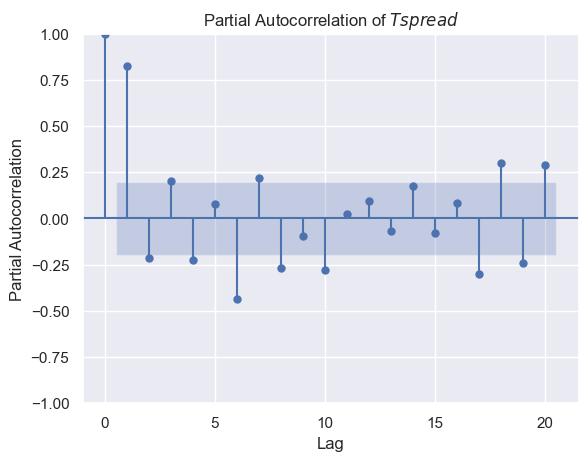

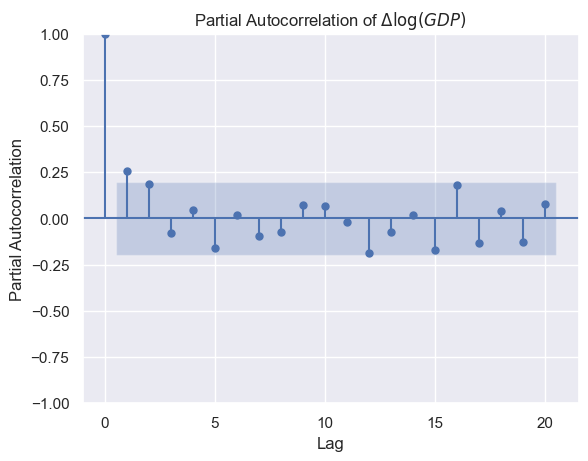

In [6]:
columns_autocorr = ['inflation', 'tspread', 'diff_log_gdp']
titles_autocorr = [ r'$Inflation(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(columns_autocorr, titles_autocorr):
    ts = sample_1[column]
    plot_pacf(ts)
    plt.title(f'Partial Autocorrelation of {title}')
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.show()

Find p for Var(p) models through AIC

In [7]:
model_vars = sample_1[['diff_log_gdp', 'inflation', 'tspread']]
ps = range(1, 25)
aics = []
for p in ps:
    # Create VAR model
    model = VAR(model_vars)
    # Fit the model with the chosen lag order
    results = model.fit(p)
    aics.append(abs(results.aic))

i = np.argmin(aics)
p_min = i + 1
aic_min = aics[i]

print(p_min, aic_min)

1 21.52242321928951


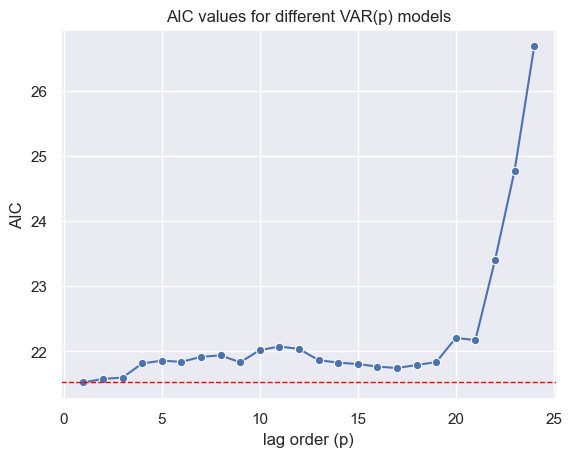

In [8]:
sns.lineplot(y=aics, x=list(ps), marker='o')
plt.xlabel('lag order (p)')
plt.ylabel('AIC')
plt.title('AIC values for different VAR(p) models')
plt.axhline(aic_min, color='red', linestyle='--', linewidth=1)

In [9]:
var1 = VAR(model_vars)
results_var1 = model.fit(1)
results_var1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Dec, 2023
Time:                     18:27:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -21.2079
Nobs:                     99.0000    HQIC:                  -21.3952
Log likelihood:           655.935    FPE:                4.49767e-10
AIC:                     -21.5224    Det(Omega_mle):     3.99376e-10
--------------------------------------------------------------------
Results for equation diff_log_gdp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.009531         0.002572            3.706           0.000
L1.diff_log_gdp         0.133974         0.096090            1.394           0.163
L1.inflation           -0.362962         0.14

In [10]:
residuals_var1 = results_var1.resid
residuals_var1['Time'] = sample_1['Time']
residuals_var1.head()

,diff_log_gdp,inflation,tspread,Time
1,0.013502,-0.004896,0.016308,1960-12-30
2,-0.018838,0.002211,0.620706,1961-03-30
3,-0.004936,-0.001555,0.031433,1961-06-30
4,-0.025086,-0.000002,0.061602,1961-09-30
5,-0.003099,-0.002430,-0.348396,1961-12-30


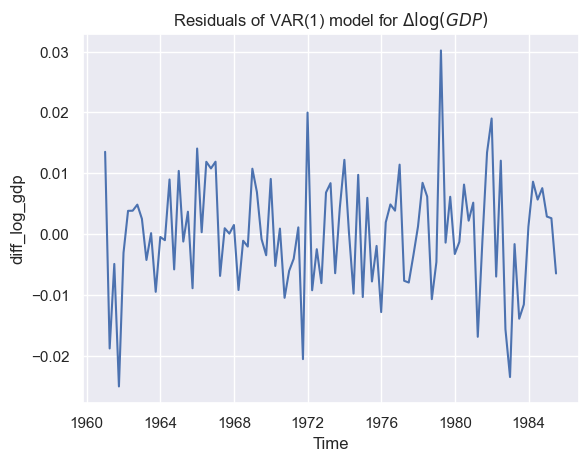

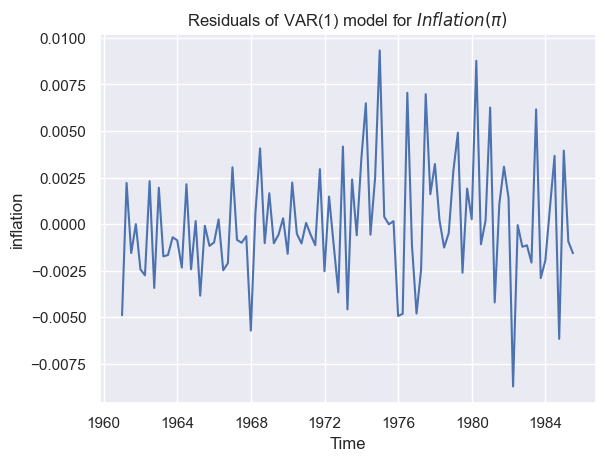

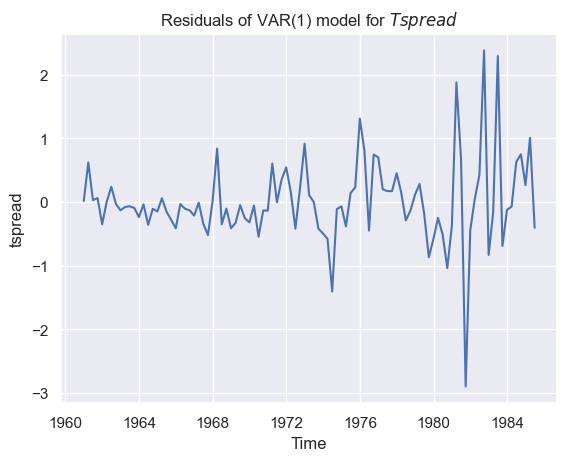

In [11]:
residuals_col = ['diff_log_gdp', 'inflation', 'tspread']
residuals_titles = [r'$\Delta \log(GDP)$', r'$Inflation(\pi)$', r'$T spread$' ]
for residual, title in zip(residuals_col, residuals_titles):
    sns.lineplot(data=residuals_var1, y=residual, x = 'Time')
    plt.title(f'Residuals of VAR(1) model for {title}')
    plt.show()

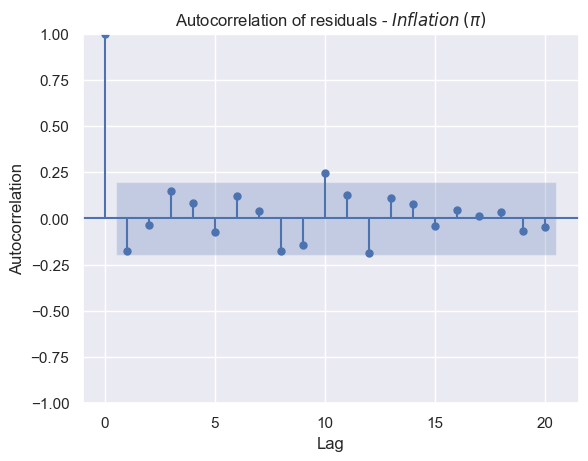

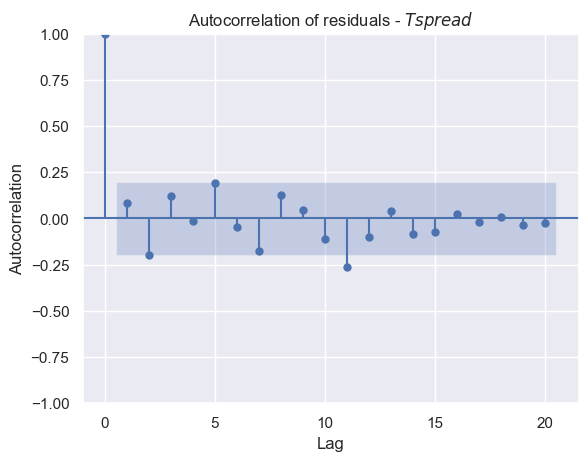

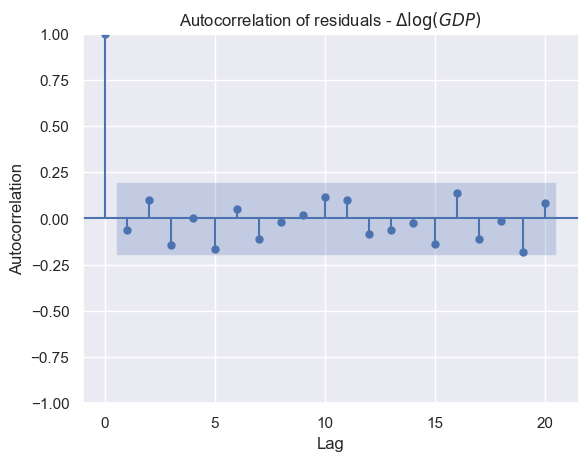

In [12]:
col_res_parcorr = ['inflation', 'tspread', 'diff_log_gdp', ]
titles_res_parcorr = [ r'$Inflation\:(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(col_res_parcorr, titles_res_parcorr):
    ts = residuals_var1[column]
    plot_acf(ts, bartlett_confint=False)
    plt.title(f'Autocorrelation of residuals - {title}')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

C:\Users\Davide\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


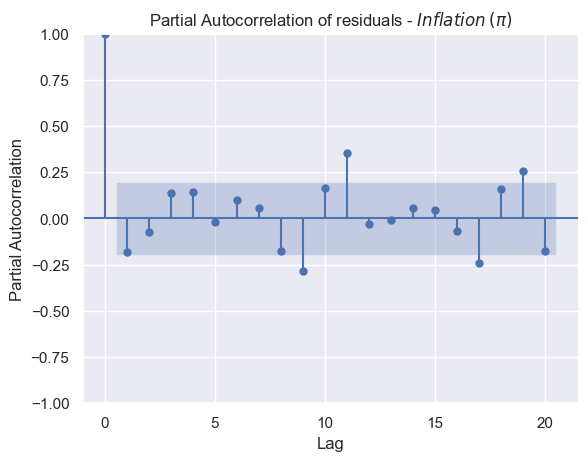

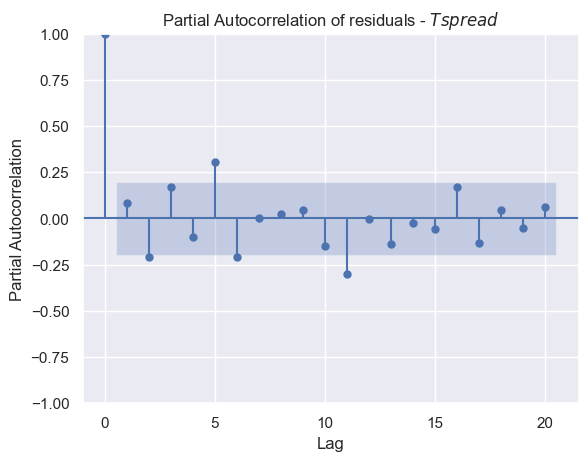

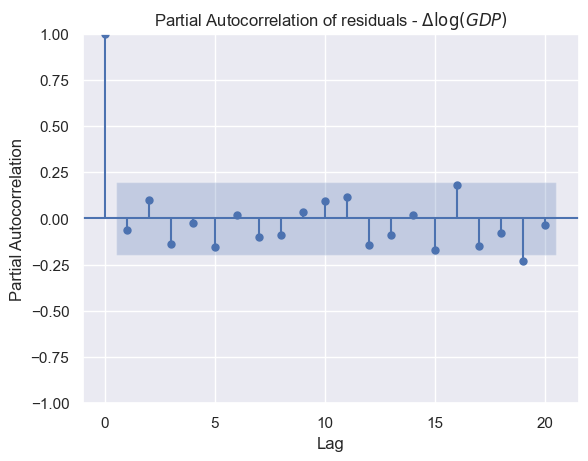

In [13]:
col_res_parcorr = ['inflation', 'tspread', 'diff_log_gdp', ]
titles_res_parcorr = [ r'$Inflation\:(\pi)$', r'$T spread$', r'$\Delta \log(GDP)$' ]

for column, title in zip(col_res_parcorr, titles_res_parcorr):
    ts = residuals_var1[column]
    plot_pacf(ts)
    plt.title(f'Partial Autocorrelation of residuals - {title}')
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.show()

## Section 3

In [14]:
raw_factors = pd.read_excel('DatiProject.xlsx', sheet_name=1)
sample_1_factors_with_time = raw_factors[(raw_factors['Time'] < '1985-07-01') & (raw_factors['Time'] > '1960-07-10')].reset_index(drop=True)
sample_1_factors = sample_1_factors_with_time.drop(['Time'], axis=1)
sample_1_factors =(sample_1_factors-sample_1_factors.mean())/sample_1_factors.std()
sample_1_factors = pd.concat([sample_1_factors_with_time["Time"], sample_1_factors], axis=1).reset_index(drop=True)

In [15]:
np.set_printoptions(suppress=True)
pca = PCA(n_components=10)
pccomps = pca.fit_transform(sample_1_factors.drop('Time', axis=1))

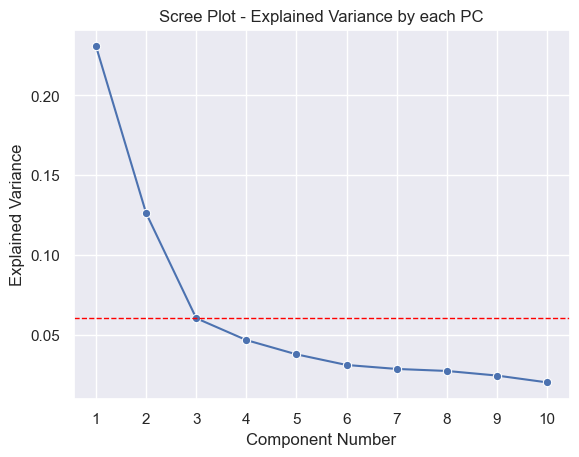

In [16]:
sns.lineplot(y = pca.explained_variance_ratio_, x = list(range(1,11)), marker="o")
plt.xticks([x for x in range(1, 11)])
plt.title("Scree Plot - Explained Variance by each PC")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.axhline(pca.explained_variance_ratio_[2], color='red', linestyle='--', linewidth=1)

In [17]:
# most important factors for first principal component
factor_importance_df = pd.DataFrame({
    'ID': list(range(1,246)),
    'Loading': abs(pca.components_[0])
})

factor_importance_df = factor_importance_df.sort_values('Loading', ascending=False)
factor_importance_df = factor_importance_df.set_index('ID').join(descriptions.set_index('ID'))

factor_importance_df.head(50)

# TODO: Actually he asks us to plot it

,Loading,SW ID,TCODE,SW Factors,FRED MNEMONIC,SW MNEMONIC,DESCRIPTION,Group
ID,,,,,,,,
38,0.124695,38,5.0,0.0,SRVPRD,Emp:Services,All Employees: Service-Providing Industries (T...,3.0
20,0.124055,20,5.0,0.0,OUTBS,Output:Bus,Business Sector: Real Output (Index 2009=100),1.0
36,0.122826,36,5.0,0.0,USPRIV,Emp:Private,All Employees: Total Private Industries (Thous...,3.0
35,0.122780,35,5.0,0.0,PAYEMS,Emp:Nonfarm,All Employees: Total nonfarm (Thousands of Per...,3.0
21,0.122346,21,5.0,0.0,OUTMS,Output:Manuf,Manufacturing Sector: Real Output (Index 2009=...,1.0
58,0.121744,58,2.0,0.0,CIVPART,LF Part Rate,Civilian Labor Force Participation Rate (Percent),3.0
34,0.121553,34,1.0,1.0,CUMFNS,Capu Man.,Capacity Utilization: Manufacturing (SIC) (Per...,2.0
191,0.121443,n.a.,2.0,0.0,B021RE1Q156NBEA,NaN,Shares of gross domestic product: Imports of g...,1.0
62,0.120962,62,2.0,1.0,LNS14000012,Urate:Age16-19,Unemployment Rate - 16 to 19 years (Percent),3.0


## Section 4

In [18]:
def RandomWalk(y):
    return ARIMA(y, order=(0,0,0)).fit()
def AutoRegressive(p, y):
    return ARIMA(y, order=(p,0,0)).fit()
def AutoRegressiveWithPC(p, y, pc):
    return ARIMA(y, order=(p,0,0), exog=pc).fit()
def VectorAutoregression(p, vars):
    return VAR(vars).fit(p)
def Standardize_Sample(sample):
    return (sample-sample.mean())/sample.std()
def Run_InSample_PCA(sample):
    return [p[0] for p in PCA(n_components=1).fit_transform(sample)]

raw_factors_notime = raw_factors.drop(['Time'], axis=1)
windows_size = 100
raw_standard_vars_till2019 = raw_standard_vars[(raw_standard_vars['Time'] < '2019-01-01') & (raw_factors['Time'] > '1960-07-10')].reset_index(drop=True)

forecasts = []
for i in range(len(raw_standard_vars_till2019)-windows_size):
    # calculate insample first principal component
    sample_factors = raw_factors_notime[i:101+i]
    sample_factors = Standardize_Sample(sample_factors)
    pc = Run_InSample_PCA(sample_factors)
    # create rolling windows
    arima_data = raw_standard_vars_till2019["diff_log_gdp"][i:100+i]
    var_data = raw_standard_vars_till2019[['diff_log_gdp', 'inflation', 'tspread']][i:100+i]
    # estimate models
    RW = RandomWalk(arima_data)
    AR4 = AutoRegressive(4, arima_data)
    VAR4 = VectorAutoregression(4, var_data)
    VAR1 = VectorAutoregression(1, var_data)
    AR4X = AutoRegressiveWithPC(4, arima_data, pc[:-1])

    forecasts.append([float(RW.forecast()), float(AR4.forecast()), float(VAR4.forecast(var_data.values[-4:], 1)[0][0]), 
                      float(VAR1.forecast(var_data.values[-1:], 1)[0][0]), float(AR4X.forecast(exog=pc[-1]))])

        

C:\Users\Davide\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Davide\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Davide\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Davide\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Davide\AppD

In [38]:
a = pd.DataFrame(forecasts, columns=['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X'])
a = pd.concat([a, raw_standard_vars["diff_log_gdp"][101:235].reset_index(drop=True)], axis=1)

for c in ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X']:
    v = sum(abs(a["diff_log_gdp"] - a[c]))
    print(v)

0.5481419491843641
0.536896301110744
0.6955151918638803
0.595430513229552
0.5235972409852824


In [39]:
for c in ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X', 'diff_log_gdp']:
    a[c + '_level'] = np.exp(raw_standard_vars['log_gdp'][100:234].reset_index(drop=True) + a[c])
a.rename(columns = {'diff_log_gdp_level': 'GDP_level'}, inplace=True)
a['Time'] = raw_standard_vars['Time'][100:234].reset_index(drop=True)
a

,RW,AR4,VAR4,VAR1,AR4X,diff_log_gdp,RW_level,AR4_level,VAR4_level,VAR1_level,AR4X_level,GDP_level,Time
0,0.008774,0.010193,0.021683,0.013837,0.009039,0.008174,8325.192359,8337.014162,8433.358445,8367.448788,8327.398755,8320.199,1985-06-30
1,0.008827,0.008463,0.013663,0.014834,0.008650,0.009643,8393.970334,8390.909913,8434.661812,8444.538859,8392.478906,8400.820,1985-09-30
2,0.008702,0.009012,0.018096,0.013858,0.009330,0.008766,8474.240584,8476.868569,8554.226873,8518.049895,8479.563150,8474.787,1985-12-30
3,0.008843,0.008978,0.018861,0.014806,0.008771,0.015157,8550.064910,8551.212413,8636.147793,8601.201109,8549.446209,8604.220,1986-03-30
4,0.008946,0.010344,0.018586,0.015996,0.008712,0.007407,8681.539148,8693.686406,8765.636300,8742.957904,8679.505050,8668.188,1986-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.006458,0.006396,0.008023,0.006058,0.006812,0.004857,19429.413839,19428.224581,19459.862236,19421.652296,19436.294200,19398.343,2017-09-30
130,0.006387,0.005721,0.004499,0.005698,0.007240,0.005583,19522.643621,19509.638060,19485.822365,19509.194018,19539.303382,19506.949,2017-12-30
131,0.006335,0.005832,0.004573,0.006218,0.007423,0.007854,19630.919557,19621.041585,19596.360262,19628.615263,19652.296494,19660.766,2018-03-30
132,0.006316,0.006594,0.007398,0.007036,0.006403,0.011207,19785.327246,19790.844954,19806.757055,19799.583680,19787.067634,19882.352,2018-06-30


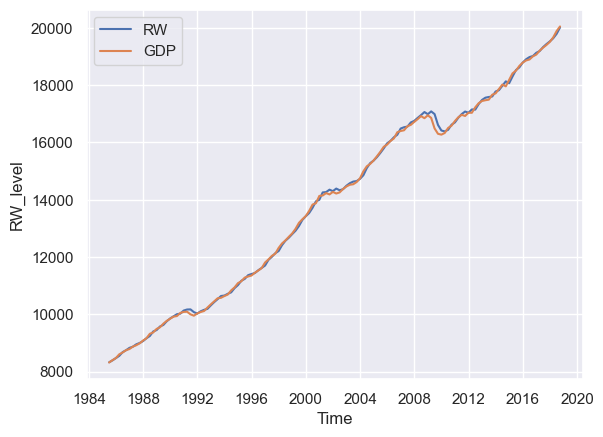

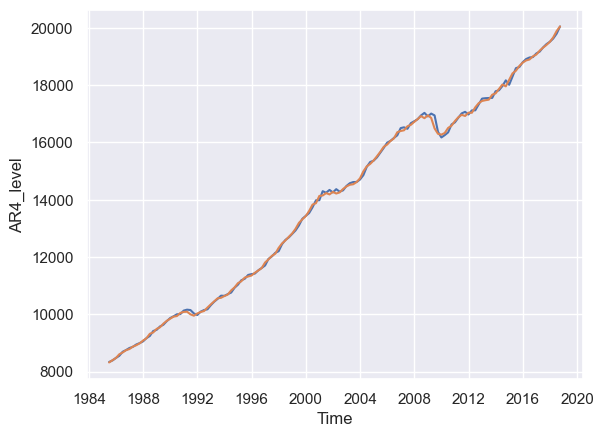

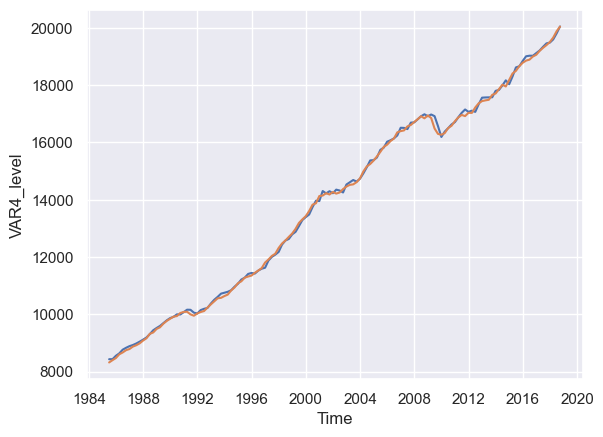

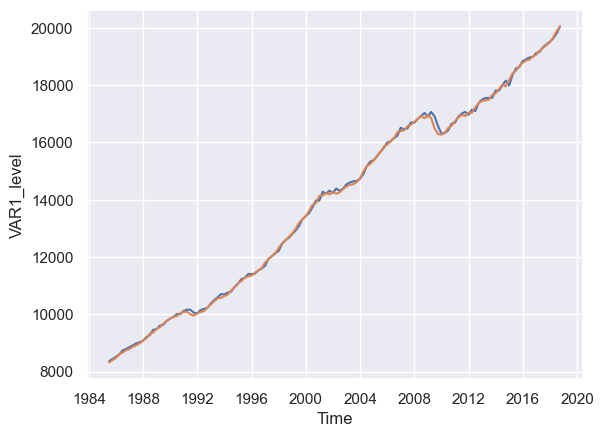

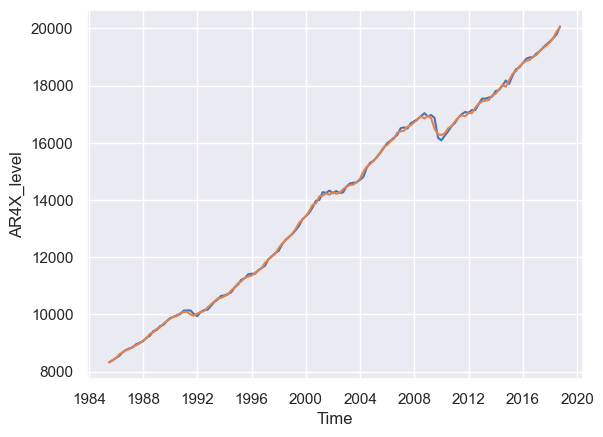

In [55]:
sns.lineplot(data=a, x='Time', y='RW_level', label='RW')
sns.lineplot(data=a, x='Time', y='GDP_level', label='GDP')
plt.legend()
plt.show()

sns.lineplot(data=a, x='Time', y='AR4_level')
sns.lineplot(data=a, x='Time', y='GDP_level')
plt.show()

sns.lineplot(data=a, x='Time', y='VAR4_level')
sns.lineplot(data=a, x='Time', y='GDP_level')
plt.show()

sns.lineplot(data=a, x='Time', y='VAR1_level')
sns.lineplot(data=a, x='Time', y='GDP_level')
plt.show()

sns.lineplot(data=a, x='Time', y='AR4X_level')
sns.lineplot(data=a, x='Time', y='GDP_level')
plt.show()


In [48]:
for c in ['RW', 'AR4', 'VAR4', 'VAR1', 'AR4X']:
    v = np.sqrt(sum((a["GDP_level"] - a[c + '_level'])**2))
    print(v)

995.9526151553991
925.5906818174595
1080.5503286357439
983.8705487608331
880.6523464818142


In [21]:
a

,RW,AR4,VAR4,VAR1,AR4X,diff_log_gdp
0,0.008774,0.010193,0.021683,0.013837,0.009039,0.008174
1,0.008827,0.008463,0.013663,0.014834,0.008650,0.009643
2,0.008702,0.009012,0.018096,0.013858,0.009330,0.008766
3,0.008843,0.008978,0.018861,0.014806,0.008771,0.015157
4,0.008946,0.010344,0.018586,0.015996,0.008712,0.007407
...,...,...,...,...,...,...
129,0.006458,0.006396,0.008023,0.006058,0.006812,0.004857
130,0.006387,0.005721,0.004499,0.005698,0.007240,0.005583
131,0.006335,0.005832,0.004573,0.006218,0.007423,0.007854
132,0.006316,0.006594,0.007398,0.007036,0.006403,0.011207
